# CauseClusterer and EffectClusterer Hyperparameter Tuning

This notebook gives a quick demo of how to tune a CauseClusterer and/or
EffectClusterer directly through CFL parameter specification.


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import visual_bars.generate_visual_bars_data as vbd
from cfl.experiment import Experiment

## Load Data
We will be using the visual bars example data for this tutorial. To learn 
more about this included dataset, please refer to the visual bars background
[page](https://cfl.readthedocs.io/en/latest/more_info/Visual_Bars_data.html).
If you would like to see a standard example of running CFL on this dataset
without hyperparameter tuning, please refer to the main CFL code 
[tutorial](https://cfl.readthedocs.io/en/latest/examples/cfl_code_intro.html).

Here, we create a dataset of 10000 samples, where the cause is a 10x10 image
and the effect is a binary 1D variable. For sake of simplicity, we will be
tuning a standard feed-forward network (as opposed to a convolutional 
neural network), so flatten the images down to vectors of shape (1,100). 

Since we want to evaluate our models on the same subset of the data across
all hyperparameter combinations, we generate in-sample and out-of-sample
indices to pass to CFL. If these are not provided, CFL generates this
split randomly, and it would look different across every trial. 

In [2]:
# create visual bars data 
n_samples = 10000 
im_shape = (10, 10) 
noise_lvl= 0.03
random_state = 180

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape=im_shape, 
                             noise_lvl=noise_lvl, set_random_seed=random_state)

# retrieve the images and the target 
X = vb_data.getImages()
X = np.reshape(X, (X.shape[0], np.product(X.shape[1:]))) # flatten images
Y = vb_data.getTarget()
Y = np.expand_dims(Y, -1)
print(X.shape)
print(Y.shape)

# define train and validation sets to remain constant across tuning
in_sample_idx, out_sample_idx = train_test_split(np.arange(X.shape[0]),
                                                 train_size=0.75,
                                                 random_state=42)

(10000, 100)
(10000, 1)


## Set up CFL pipeline
Here, we assume we have already tuned the CDE and will focus on tuning
the CauseClusterer (as can be seen from the loss plot below, this assumption
is very wrong). 
The CauseClusterer expects the user to specify the `'model`' they would
like to use (usually an sklearn model), along with any associated 
hyperparameters they would like to specify through a `model_params` dict:

```
CauseClusterer_params = {'model'         : 'DBSCAN', # sklearn model
                         'model_params'  : { 
                            'eps'        : 0.1,      # dbscan hyperparam
                            'min_samples : 10},      # dbscan hyperparam
                         'verbose'       : 0,        # CFL verbosity setting
                         'tune'          : False     # default is False
                        }
```

This syntax can be extended to tune the clusterer over a range of hyperparameters
by making all model parameters iterable:

```
CauseClusterer_params = {'model'        : ['DBSCAN'],             # sklearn model (formatted 
                                                                  # as list for compatibility)
                         'model_params' : {
                            'eps'        : np.logspace(-5,2,10),  # try 10 values of `eps` 
                            'min_samples : np.linspace(10,60,5)}, # try 5 values of `min_samples`
                         'verbose'    : 0                         # CFL verbosity setting (does 
                                                                  # not need to be iterable because 
                                                                  # filtered out as cfl param)
                         'tune'       : True                      # default is False
                        }
```


In [5]:
# the parameters should be passed in dictionary form 
data_info = {'X_dims' : X.shape, 
             'Y_dims' : Y.shape, 
             'Y_type' : 'categorical' #options: 'categorical' or 'continuous'
            }

# the optimal hyperparameters for the CDE can be found by following the
# Optuna tuning tutorial
CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    'dense_units'      : [160, data_info['Y_dims'][1]],
                    'activations'      : ['relu', 'linear'],
                    'dropouts'         : [0.1, 0],
                    'kernel_regularizers' : [None] * 2,
                    'bias_regularizers' : [None] * 2,
                    'activity_regularizers' : [None] * 2,
                    'batch_size'       : 72, 
                    'n_epochs'         : 100,
                    'optimizer'        : 'adam',
                    'opt_config'       : {'lr' : 4e-05},
                    'loss'             : 'mean_squared_error',
                    'best'             : True, 
                    'verbose'          : 1}
            }

# CauseClusterer_params = {'model'        : 'DBSCAN', 
#                          'model_params' : {
#                             'eps'         : np.logspace(-3.5,-1,15),
#                             'min_samples' : np.arange(30,300,30).astype(int)},  
#                         'verbose'     : 1,
#                         'tune'        : True
#                        }

CauseClusterer_params = {'model'        : 'KMeans', 
                         'model_params' : {
                            'n_clusters' : np.arange(2,11).astype(int)},
                        'verbose'     : 1,
                        'tune'        : True
                       }
# steps of this CFL pipeline
block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, CauseClusterer_params]

# folder to save results to 
save_path = 'visual_bars_cfl' 

# create the experiment!
my_exp = Experiment(X_train=X, 
                    Y_train=Y, 
                    data_info=data_info, 
                    block_names=block_names, 
                    block_params=block_params, 
                    results_path=save_path)

All results from this run will be saved to visual_bars_cfl/experiment0017
Block: verbose not specified in input, defaulting to 1
CondExpBase: kernel_initializers not specified in input, defaulting to None
CondExpBase: bias_initializers not specified in input, defaulting to None
CondExpBase: weights_path not specified in input, defaulting to None
CondExpBase: show_plot not specified in input, defaulting to True
CondExpBase: tb_path not specified in input, defaulting to None
CondExpBase: optuna_callback not specified in input, defaulting to None
CondExpBase: optuna_trial not specified in input, defaulting to None
CondExpBase: early_stopping not specified in input, defaulting to False
CondExpBase: checkpoint_name not specified in input, defaulting to tmp_checkpoints
Block: user_input not specified in input, defaulting to True


#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
No GPU device detected.
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
104/105 [============================>.] - ETA: 0s - loss: 1.3172WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x1a53234320> and will run it as-is.
Please rep

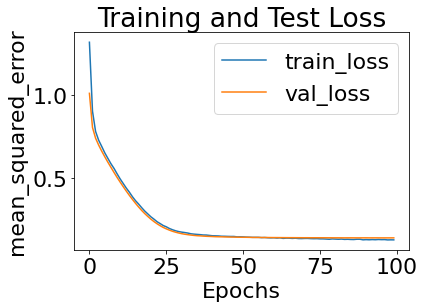

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


0it [00:00, ?it/s]

Loading parameters from  tmp_checkpoints01042022185134/best_weights
Saving parameters to  visual_bars_cfl/experiment0017/trained_blocks/CondDensityEstimator
CondDensityEstimator training complete.
Beginning CauseClusterer training...
Beginning clusterer tuning


9it [00:06,  1.46it/s]


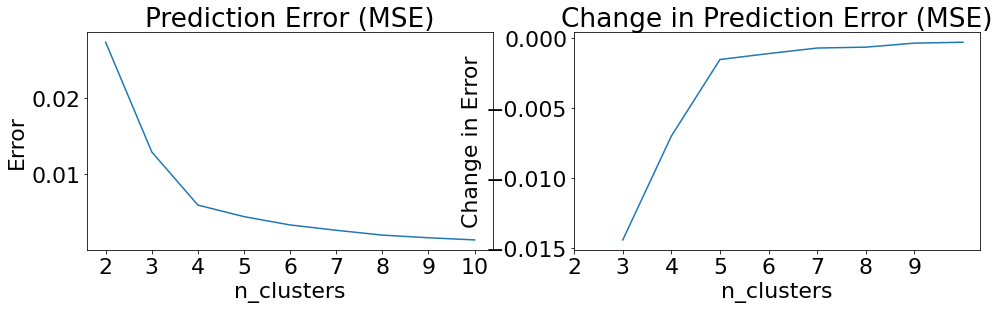

Please choose your final clustering parameters.
Final parameters:  {'n_clusters': 4}
CauseClusterer training complete.
Experiment training complete.


In [6]:
train_results = my_exp.train()

## Visualize the conditional probability learned by CFL with the optimized hyperparameters

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Sample of predicted P(Y|X) values after CDE training\nColored by ground truth'}, xlabel='Sample', ylabel='Expectation of Target'>)

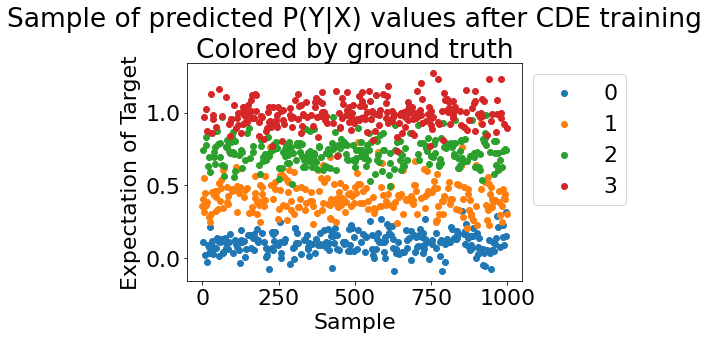

In [7]:
from cfl.visualization.cde_diagnostic import pyx_scatter
from importlib import reload
import cfl.visualization.cde_diagnostic as cvc
reload(cvc) 
# first by ground truth macrostates
cvc.pyx_scatter(my_exp, vb_data.getGroundTruth(), colored_by='ground truth')

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Sample of predicted P(Y|X) values after CDE training\nColored by cause macrostate'}, xlabel='Sample', ylabel='Expectation of Target'>)

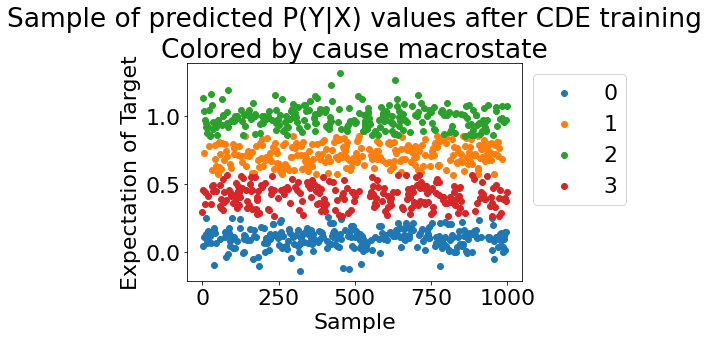

In [8]:
# now color by learned macrostates
cvc.pyx_scatter(my_exp, train_results['CauseClusterer']['x_lbls'], 
    colored_by='cause macrostate')